In [2]:
import ee
import geemap
import os

In [3]:
ee.Authenticate()


Successfully saved authorization token.


In [4]:
ee.Initialize()

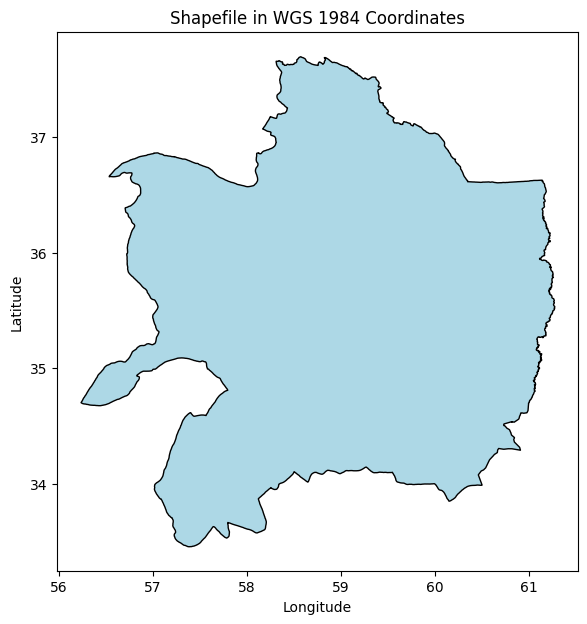

In [11]:
import geopandas as gpd
import matplotlib.pyplot as plt

# Load your shapefile (replace with the correct path)
shapefile_path = r"G:\Milirati_Project\GIS\Province2\province.shp"
gdf = gpd.read_file(shapefile_path)

# Convert the GeoDataFrame to WGS 1984 (EPSG:4326) if it's not already in that CRS
gdf = gdf.to_crs(epsg=4326)

# Plot the shapefile
gdf.plot(figsize=(7, 7), edgecolor='black', facecolor='lightblue')

# Add title and labels
plt.title('Shapefile in WGS 1984 Coordinates')
plt.xlabel('Longitude')
plt.ylabel('Latitude')

# Show the plot
plt.show()


In [ ]:
import geemap
import ee
import geopandas as gpd
import datetime
import os

# Configuration Section
CONFIG = {
    # Input shapefile
    'shapefile_path': r"G:\Milirati_Project\GIS\Province2\province.shp",
    
    # Data source
    'data_source': "UCSB-CHG/CHIRPS/DAILY",
    'data_band': "precipitation",
    
    # Date range
    'start_year': 2020,
    'end_year': 2021,
    'start_month': 1,
    'end_month': 12,
    
    # Output specifications
    'output_directory': r"G:\test_code",
    'output_crs': "EPSG:4326",
    'output_resolution': 0.01,  # in degrees (~1km at equator)
    
    # Output file naming
    'output_prefix': "CHIRPS_Pr_Monthly_1km_ROI"
}

def download_chirps_data(config):
    """
    Download CHIRPS precipitation data for specified region and time period.
    
    Args:
        config (dict): Configuration dictionary containing all necessary parameters
    """
    # Initialize Earth Engine
    ee.Initialize()
    
    # Create output directory if it doesn't exist
    os.makedirs(config['output_directory'], exist_ok=True)
    
    # Load and prepare the shapefile
    gdf = gpd.read_file(config['shapefile_path'])
    gdf = gdf.to_crs(config['output_crs'])
    region = geemap.geojson_to_ee(gdf.__geo_interface__)
    
    # Convert FeatureCollection to Geometry if necessary
    if isinstance(region, ee.FeatureCollection):
        region = region.geometry()
    
    # Loop through years and months
    for year in range(config['start_year'], config['end_year'] + 1):
        for month in range(config['start_month'], config['end_month'] + 1):
            try:
                # Define start and end dates
                monthly_start_date = f"{year}-{month:02d}-01"
                if month == 12:
                    monthly_end_date = f"{year+1}-01-01"
                else:
                    monthly_end_date = f"{year}-{month+1:02d}-01"
                
                # Load and process CHIRPS dataset
                monthly_collection = (
                    ee.ImageCollection(config['data_source'])
                    .filterBounds(region)
                    .filterDate(monthly_start_date, monthly_end_date)
                    .select(config['data_band'])
                )
                
                # Calculate monthly sum
                monthly_sum = monthly_collection.sum()
                
                # Set timestamp
                timestamp = ee.Date(monthly_start_date).millis()
                monthly_sum = monthly_sum.set("system:time_start", timestamp)
                
                # Convert to xarray dataset
                ds_monthly = geemap.ee_to_xarray(
                    monthly_sum,
                    crs=config['output_crs'],
                    scale=config['output_resolution'],
                    geometry=region
                )
                
                # Define and save output
                output_filename = f"{config['output_prefix']}_{year}_{month:02d}.nc"
                monthly_output_path = os.path.join(config['output_directory'], output_filename)
                
                ds_monthly.to_netcdf(monthly_output_path)
                print(f"Monthly NetCDF file saved to: {monthly_output_path}")
                
            except Exception as e:
                print(f"Error processing {year}-{month:02d}: {str(e)}")
                continue

if __name__ == "__main__":
    download_chirps_data(CONFIG)

In [28]:
import xarray as xr

# Open a single NetCDF file
file_path = 'G:\Milirati_Project\dataset_LST.nc'
Data = xr.open_dataset(file_path)
Data

<xarray.Dataset>
Dimensions:    (time: 287, latitude: 347, longitude: 322)
Coordinates:
  * time       (time) datetime64[ns] 2000-01-31 2000-02-29 ... 2023-12-31
  * latitude   (latitude) float64 33.0 32.99 32.98 32.97 ... 29.9 29.9 29.89
  * longitude  (longitude) float64 47.66 47.67 47.68 47.69 ... 50.53 50.54 50.55
Data variables:
    value      (time, latitude, longitude) float64 ...

--- Step 1: Loading and Preparing Data ---
Data loaded and clipped successfully.

--- Step 2: Analyzing Overall Time Series ---

Overall Descriptive Statistics:
count    287.000000
mean      35.911915
std       11.949776
min       14.069077
25%       24.654046
50%       38.488368
75%       47.516697
max       52.568300
Name: value, dtype: float64


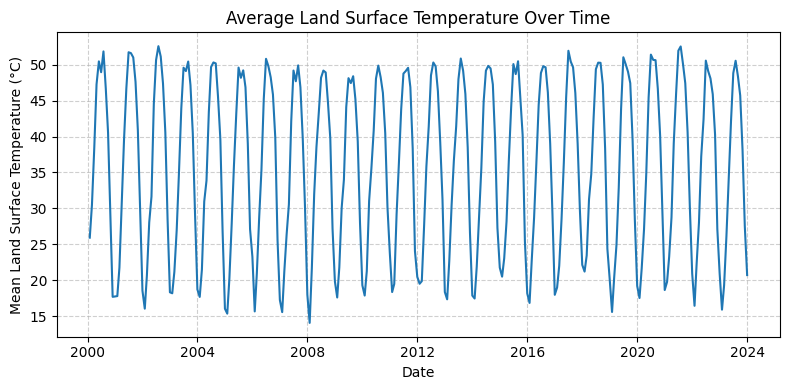


--- Step 3: Analyzing Annual Mean ---

Annual Mean LST:
year
2000    38.842992
2001    37.331310
2002    35.829985
2003    35.802521
2004    35.463710
2005    35.489571
2006    35.268200
2007    34.785031
2008    35.608487
2009    35.265128
2010    36.101156
2011    35.342924
2012    35.658988
2013    35.451808
2014    36.052861
2015    35.892371
2016    35.801401
2017    36.678106
2018    36.102925
2019    35.183474
2020    36.186199
2021    37.532084
2022    35.690406
2023    34.768580
Name: value, dtype: float64


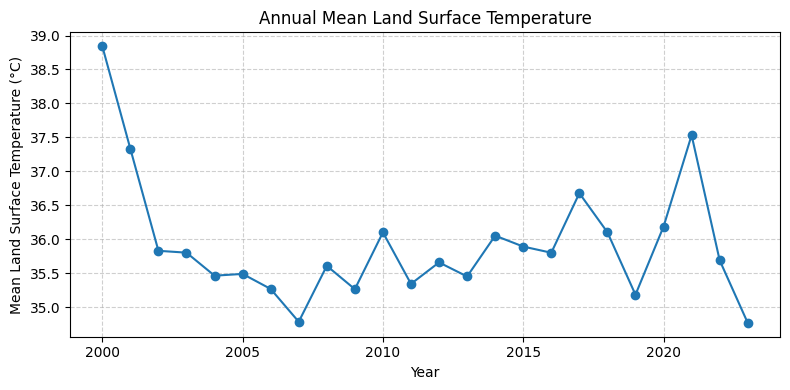


--- Step 4 & 5: Analyzing Data Distribution with Box Plots ---


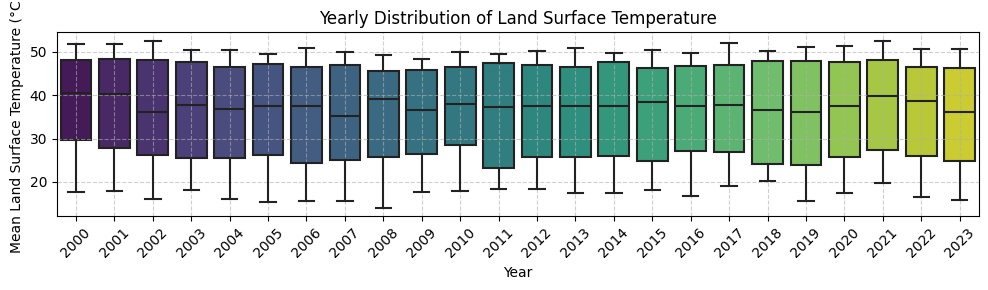

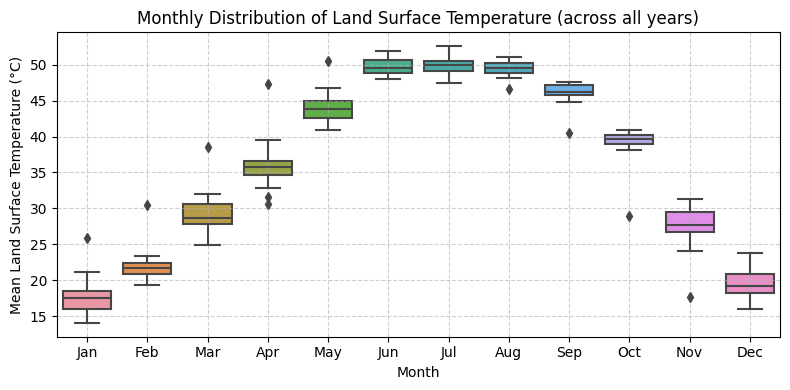


--- Step 6: Generating Mean Spatial Map ---


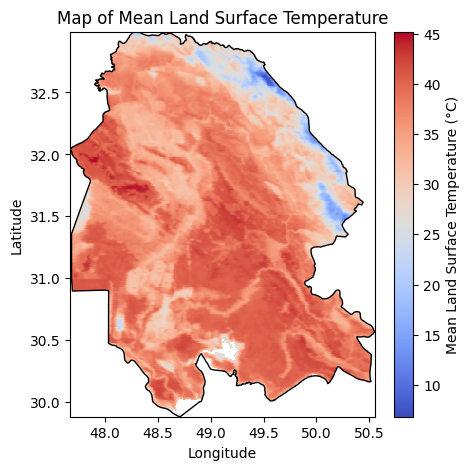


All analysis complete.


In [10]:
# =============================================================================
#         SPATIAL AND TEMPORAL VALIDATION OF CLIMATIC DATA
# =============================================================================
#
# Author: [Ali Rezaee]
# Date: June 15, 2025
#
# Description:
# This script provides a comprehensive workflow to analyze and visualize gridded
# climatic data (e.g., from a NetCDF file) for a specific region of interest
# defined by a shapefile. It is designed to be easily adaptable for various
# climatic variables like Land Surface Temperature (LST), precipitation, air
# temperature, etc.
#
# The script performs the following steps:
#   1. Loads a NetCDF dataset and a shapefile.
#   2. Clips the gridded data to the shapefile's geographic extent.
#   3. Calculates and plots the overall time series of the regional average.
#   4. Calculates and plots the annual mean trend.
#   5. Generates box plots showing the data distribution for each year and month.
#   6. Creates and plots a map of the long-term spatial mean.
#
# =============================================================================

import xarray as xr
import geopandas as gpd
import rioxarray
import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns

# =============================================================================
# --- USER CONFIGURATION ---
# All user-specific settings should be changed in this section.
# =============================================================================

# 1. FILE PATHS
# --- IMPORTANT: Update these paths to point to your data files. ---
# Use 'r' before the string to handle Windows paths correctly.
NETCDF_FILE_PATH = r'G:\Milirati_Project\dataset_LST.nc'
SHAPEFILE_PATH = r'H:\LST_KH\Data_Back\Province_KH_DD\province_Project1.shp'

# 2. NETCDF VARIABLE & COORDINATE NAMES
# --- Find these names by inspecting your NetCDF file (e.g., with `print(xr.open_dataset(NETCDF_FILE_PATH))`) ---
DATA_VARIABLE_NAME = 'value'      # The name of the data variable you want to analyze (e.g., 'lst', 't2m', 'precip').
X_COORD_NAME = 'longitude'        # The name of the X-axis / longitude coordinate in your NetCDF file.
Y_COORD_NAME = 'latitude'         # The name of the Y-axis / latitude coordinate in your NetCDF file.

# 3. PLOT CUSTOMIZATION
# --- These settings will be used in plot titles and labels. ---
VARIABLE_LONG_NAME = 'Land Surface Temperature' # A descriptive name for your variable.
VARIABLE_UNITS = '°C'                         # The units of your data (e.g., '°C', 'Kelvin', 'mm/day').

# 4. DATA PROCESSING OPTIONS
# --- Set to True to enable specific processing steps. ---
CONVERT_K_TO_C = False # Set to True if your data is in Kelvin and you want to convert to Celsius.

# =============================================================================
# --- END OF USER CONFIGURATION ---
# Do not edit below this line unless you want to change the analysis logic.
# =============================================================================

def main():
    """
    Main function to run the entire analysis workflow.
    """
    # --- 1. SETUP AND DATA LOADING ---
    print("--- Step 1: Loading and Preparing Data ---")
    try:
        data = xr.open_dataset(NETCDF_FILE_PATH)
        gdf = gpd.read_file(SHAPEFILE_PATH)
    except FileNotFoundError as e:
        print(f"Error: A file was not found. Please check your file paths in the configuration section.")
        print(f"Details: {e}")
        return

    data = data.rio.set_spatial_dims(x_dim=X_COORD_NAME, y_dim=Y_COORD_NAME)
    data = data.rio.write_crs('epsg:4326')
    gdf = gdf.to_crs(data.rio.crs)
    clipped_data = data.rio.clip(gdf.geometry, drop=True)

    if DATA_VARIABLE_NAME not in clipped_data:
        raise ValueError(f"Variable '{DATA_VARIABLE_NAME}' not found. Available variables: {list(clipped_data.data_vars)}")
    print("Data loaded and clipped successfully.")

    # --- 2. OVERALL TIME SERIES ANALYSIS ---
    print("\n--- Step 2: Analyzing Overall Time Series ---")
    time_series_mean = clipped_data[DATA_VARIABLE_NAME].mean(dim=[Y_COORD_NAME, X_COORD_NAME])

    if CONVERT_K_TO_C:
        time_series_mean = time_series_mean - 273.15
        print("Data converted from Kelvin to Celsius.")

    print("\nOverall Descriptive Statistics:")
    print(time_series_mean.to_pandas().describe())

    plt.figure(figsize=(8, 4))
    time_series_mean.plot()
    plt.title(f'Average {VARIABLE_LONG_NAME} Over Time')
    plt.xlabel('Date')
    plt.ylabel(f'Mean {VARIABLE_LONG_NAME} ({VARIABLE_UNITS})')
    plt.grid(True, linestyle='--', alpha=0.6)
    plt.tight_layout()
    plt.show()

    # --- 3. ANNUAL ANALYSIS (LINE PLOT) ---
    print("\n--- Step 3: Analyzing Annual Mean ---")
    annual_mean = time_series_mean.groupby(time_series_mean.time.dt.year).mean()
    print("\nAnnual Mean LST:")
    print(annual_mean.to_pandas())

    plt.figure(figsize=(8, 4))
    annual_mean.plot(marker='o', linestyle='-')
    plt.title(f'Annual Mean {VARIABLE_LONG_NAME}')
    plt.ylabel(f'Mean {VARIABLE_LONG_NAME} ({VARIABLE_UNITS})')
    plt.xlabel('Year')
    plt.grid(True, linestyle='--', alpha=0.6)
    plt.tight_layout()
    plt.show()

    # --- 4. & 5. BOX PLOT ANALYSIS ---
    print("\n--- Step 4 & 5: Analyzing Data Distribution with Box Plots ---")
    df = time_series_mean.to_pandas().to_frame(name='data_values')
    df['year'] = df.index.year
    df['month'] = df.index.strftime('%b')

    # Yearly Box Plot
    plt.figure(figsize=(10, 3))
    sns.boxplot(data=df, x='year', y='data_values', palette='viridis')
    plt.title(f'Yearly Distribution of {VARIABLE_LONG_NAME}')
    plt.xlabel('Year')
    plt.ylabel(f'Mean {VARIABLE_LONG_NAME} ({VARIABLE_UNITS})')
    plt.xticks(rotation=45)
    plt.grid(True, linestyle='--', alpha=0.6)
    plt.tight_layout()
    plt.show()

    # Monthly Box Plot
    month_order = ['Jan', 'Feb', 'Mar', 'Apr', 'May', 'Jun', 'Jul', 'Aug', 'Sep', 'Oct', 'Nov', 'Dec']
    plt.figure(figsize=(8, 4))
    sns.boxplot(data=df, x='month', y='data_values', order=month_order)
    plt.title(f'Monthly Distribution of {VARIABLE_LONG_NAME} (across all years)')
    plt.xlabel('Month')
    plt.ylabel(f'Mean {VARIABLE_LONG_NAME} ({VARIABLE_UNITS})')
    plt.grid(True, linestyle='--', alpha=0.6)
    plt.tight_layout()
    plt.show()

    # --- 6. SPATIAL MAP OF THE MEAN ---
    print("\n--- Step 6: Generating Mean Spatial Map ---")
    mean_spatial_map = clipped_data[DATA_VARIABLE_NAME].mean(dim='time')

    if CONVERT_K_TO_C:
        mean_spatial_map = mean_spatial_map - 273.15

    fig, ax = plt.subplots(figsize=(5, 5))
    mean_spatial_map.plot(ax=ax, cmap='coolwarm', cbar_kwargs={'label': f'Mean {VARIABLE_LONG_NAME} ({VARIABLE_UNITS})'})
    gdf.plot(ax=ax, facecolor='none', edgecolor='black', linewidth=1)
    ax.set_title(f'Map of Mean {VARIABLE_LONG_NAME}')
    ax.set_xlabel('Longitude')
    ax.set_ylabel('Latitude')
    plt.show()

    print("\nAll analysis complete.")

if __name__ == "__main__":
    main()